#**Import Library**

In [ ]:
!pip install tensorflow==2.8.3

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.3


In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#**Download Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Location of the zip file containing the fish image dataset
zip_path = '/content/drive/MyDrive/ML CAPSTONE/Dataset_Ikan_Revisi.zip'
# Location of the directory where the zip file will be extracted
extract_dir = '/content/drive/MyDrive/CAPSTONE/Dataset_Ikan'
# Create an 'extract_dir' directory if it does not already exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file and extract its contents to the 'extract_dir' directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

#**Cleaning Dataset**

In [ ]:
# PIL to extract images and cv2 for additional image validation using OpenCV
from PIL import Image
import cv2

# Directory to save cleaned images
cleaned_dir = '/content/drive/MyDrive/CAPSTONE/Dataset_Ikan'

def is_image_valid(image_path):
    try:
        # Open image with PIL to check if it's valid
        img = Image.open(image_path)
        img.verify()
        # Open image with OpenCV to ensure it can be processed
        img_cv = cv2.imread(image_path)
        if img_cv is None:
            return False
        return True
    except (IOError, SyntaxError):
        return False

def process_image(image_path, output_path):
    try:
        # Open image with PIL
        img = Image.open(image_path)
        # Convert image to RGB (if not already in that mode)
        img = img.convert('RGB')
        # Resize image
        img = img.resize((224, 224))
        # Save cleaned image
        img.save(output_path)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Iterate over each folder and image
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_path = os.path.join(root, file)
            if is_image_valid(image_path):
                # Define output path
                relative_path = os.path.relpath(image_path, extract_dir)
                output_path = os.path.join(cleaned_dir, relative_path)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                # Process and save the cleaned image
                process_image(image_path, output_path)
            else:
                print(f"Invalid image found and skipped: {image_path}")

In [ ]:
folder_path = r'/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/Dataset_Ikan/'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

Overall, this code performs image extraction, validation, conversion and storage to ensure the fish image dataset is ready to be used for model training.

#**Organizing Dataset**

In [ ]:
!pip install split-folders

In [ ]:
# A library used to divide a dataset into different sub-folders based on a certain ratio
import splitfolders
# The location of the directory containing the cleaned and processed fish image dataset
input_folder = '/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/Dataset_Ikan/'

# Seed to ensure the dataset split is consistent each time the code is run, ensuring the same result each time the split is performed
# group_prefix=None used if we want to group files with the same prefix
splitfolders.ratio(input_folder, output='outputs',
                   seed=42, ratio=(.7, .2, .1),
                   group_prefix=None)

Copying files: 800 files [00:07, 110.27 files/s]


Overall, this code is an important part of the data processing pipeline before training a machine learning model, ensuring the data is broken down proportionally and ready to use for various stages of training and evaluation.

#**Training and Validation Generator**

Sample   Nila:


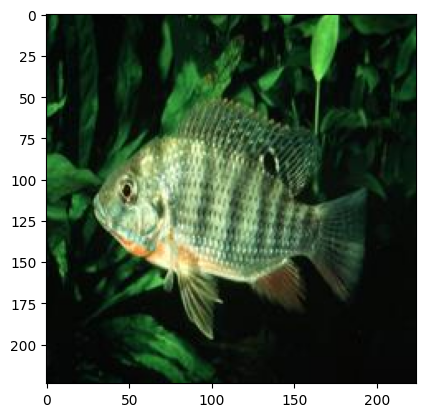

Sample Ikan Mas:


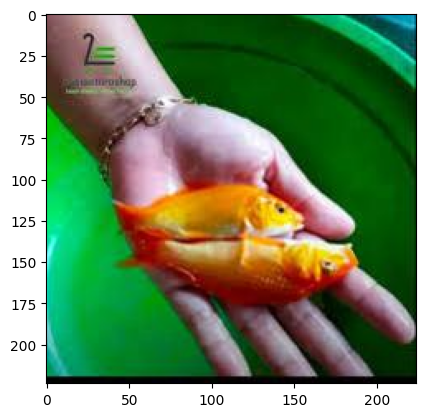

In [ ]:
# Definition of train, val, and test directories
train_dir = './outputs/train'
val_dir = './outputs/val'
test_dir = './ouputs/test'

# Display sample images from the 'Nila' and 'Ikan Mas' categories in the training dataset
print("Sample   Nila:")
nila_img_path = os.path.join('./outputs/train/Nila', os.listdir('./outputs/train/Nila')[0])
plt.imshow(load_img(nila_img_path))
plt.show()

print("Sample Ikan Mas:")
ikanmas_img_path = os.path.join('./outputs/train/Ikan Mas', os.listdir('./outputs/train/Ikan Mas')[0])
plt.imshow(load_img(ikanmas_img_path))
plt.show()

In [ ]:
def train_val_generator(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     fill_mode = 'nearest',
                                     horizontal_flip = True)
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      target_size=(224,224),
                                                      shuffle=True)
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      target_size=(224,224))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generator(train_dir, val_dir)

Found 560 images belonging to 5 classes.
Found 160 images belonging to 5 classes.


In [ ]:
# Function of TF to create datasets from directories
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=(224, 224))

Found 560 files belonging to 5 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['Gabus', 'Ikan Mas', 'Lele', 'Nila', 'Patin']


In [ ]:
# Library to check and confirm the image file type
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/Dataset_Ikan/outputs"
image_extensions = [".png", ".jpg"]  # list of image file extensions to check

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"] # list of image file types accepted by TF
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath) # check the file type
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

Overall, this code displays image samples from the dataset, creating training and validation data generators with data augmentation to improve model performance. Checks image file types in the dataset to ensure all image files are valid and usable by TensorFlow.

#**Build Model**

In [ ]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=2,
                    validation_data=validation_generator,
                    verbose=2,
                    validation_steps=2)

Epoch 1/100
2/2 - 39s - loss: 1.7657 - accuracy: 0.2500 - val_loss: 1.7683 - val_accuracy: 0.1953 - 39s/epoch - 19s/step
Epoch 2/100
2/2 - 36s - loss: 1.6711 - accuracy: 0.1953 - val_loss: 1.6067 - val_accuracy: 0.1875 - 36s/epoch - 18s/step
Epoch 3/100
2/2 - 34s - loss: 1.6071 - accuracy: 0.1875 - val_loss: 1.5964 - val_accuracy: 0.2031 - 34s/epoch - 17s/step
Epoch 4/100
2/2 - 34s - loss: 1.5983 - accuracy: 0.2109 - val_loss: 1.5931 - val_accuracy: 0.2656 - 34s/epoch - 17s/step
Epoch 5/100
2/2 - 33s - loss: 1.5825 - accuracy: 0.2500 - val_loss: 1.5533 - val_accuracy: 0.3359 - 33s/epoch - 16s/step
Epoch 6/100
2/2 - 33s - loss: 1.5801 - accuracy: 0.2500 - val_loss: 1.6015 - val_accuracy: 0.2266 - 33s/epoch - 16s/step
Epoch 7/100
2/2 - 32s - loss: 1.5457 - accuracy: 0.2321 - val_loss: 1.5756 - val_accuracy: 0.2578 - 32s/epoch - 16s/step
Epoch 8/100
2/2 - 30s - loss: 1.4369 - accuracy: 0.3661 - val_loss: 1.8885 - val_accuracy: 0.2500 - 30s/epoch - 15s/step
Epoch 9/100
2/2 - 33s - loss: 1.

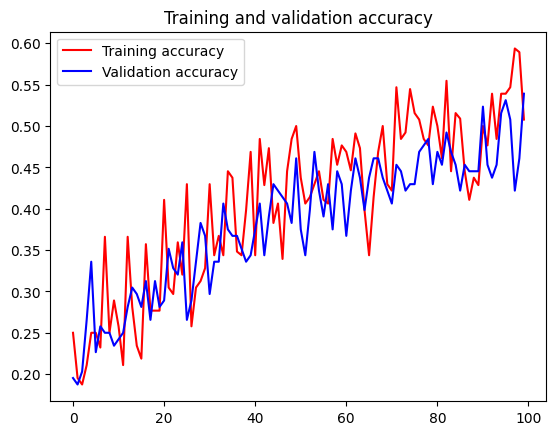

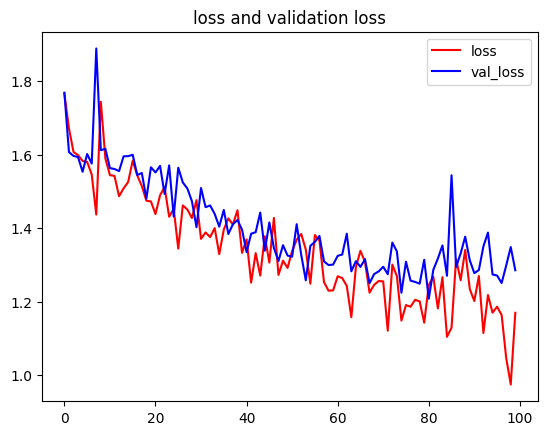

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Overall, this code defines a Convolutional Neural Network (CNN) model designed to classify fish images into five different categories. The input image goes through several convolution and pooling layers to extract features. The output of the convolution layer is flattened and goes through dense layers for final classification. Dropout to prevent overfitting.

#**Transfer Learning**

**Using pre trained model InceptionV3**

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-03 01:45:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.207, 142.251.167.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  97.1MB/s    in 0.9s    

2024-06-03 01:45:38 (97.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(224, 224, 3))

  # pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)           

Overall, this code prepares a pre-trained InceptionV3 model to be used as a basis for building a new model for the task of fish image classification. This model will not retrain the base layers of InceptionV3, but only additional layers added on top of it.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense (256, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense (5, activation='softmax')(x)
model2 = Model(pre_trained_model.input, x)
model2.summary()

model2.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                             

In [ ]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 80,
                    steps_per_epoch = 2,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

Epoch 1/80
2/2 - 37s - loss: 1.7113 - accuracy: 0.2578 - val_loss: 1.2963 - val_accuracy: 0.5500 - 37s/epoch - 18s/step
Epoch 2/80
2/2 - 33s - loss: 1.4324 - accuracy: 0.3672 - val_loss: 1.1316 - val_accuracy: 0.6062 - 33s/epoch - 17s/step
Epoch 3/80
2/2 - 30s - loss: 1.2313 - accuracy: 0.5714 - val_loss: 1.0559 - val_accuracy: 0.5938 - 30s/epoch - 15s/step
Epoch 4/80
2/2 - 33s - loss: 1.0580 - accuracy: 0.6250 - val_loss: 0.8022 - val_accuracy: 0.7125 - 33s/epoch - 16s/step
Epoch 5/80
2/2 - 31s - loss: 1.0335 - accuracy: 0.5938 - val_loss: 0.6656 - val_accuracy: 0.7188 - 31s/epoch - 16s/step
Epoch 6/80
2/2 - 30s - loss: 0.7747 - accuracy: 0.6964 - val_loss: 0.6671 - val_accuracy: 0.7125 - 30s/epoch - 15s/step
Epoch 7/80
2/2 - 31s - loss: 0.8551 - accuracy: 0.6562 - val_loss: 0.6203 - val_accuracy: 0.7500 - 31s/epoch - 16s/step
Epoch 8/80
2/2 - 38s - loss: 0.7330 - accuracy: 0.7188 - val_loss: 0.5590 - val_accuracy: 0.8062 - 38s/epoch - 19s/step
Epoch 9/80
2/2 - 30s - loss: 0.5316 - ac

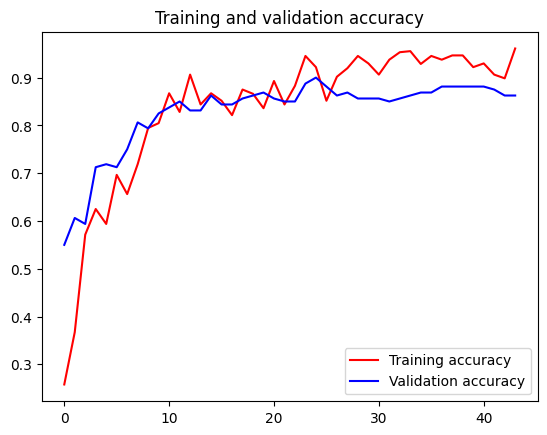

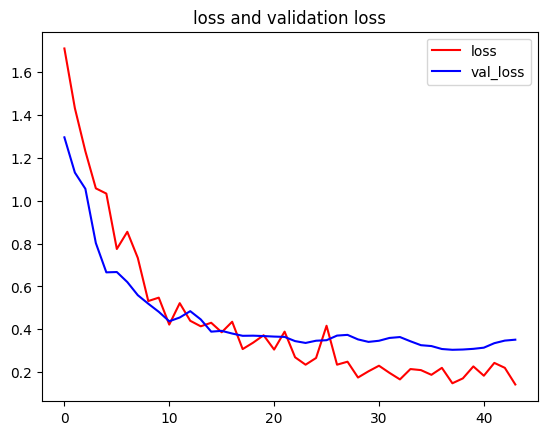

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Overall, this code uses a transfer learning approach with pre-trained InceptionV3, adds a fully connected layer for classification, and compiles a new model for further training. This model is expected to achieve high accuracy by utilizing the features that have been learned by InceptionV3.

#**Fine Tuning**

In [ ]:
from tensorflow import keras
pre_trained_model.trainable = True


model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy']
)

epochs = 15
model2.fit(train_generator,
           validation_data=validation_generator,
          epochs=epochs
         )

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 291s 31s/step - loss: 0.2761 - accuracy: 0.9214 - val_loss: 0.3709 - val_accuracy: 0.8750
Epoch 2/15
9/9 [==============================] - 285s 32s/step - loss: 0.2608 - accuracy: 0.9071 - val_loss: 0.3335 - val_accuracy: 0.8938
Epoch 3/15
9/9 [==============================] - 274s 30s/step - loss: 0.1873 - accuracy: 0.9518 - val_loss: 0.3031 - val_accuracy: 0.9062
Epoch 4/15
9/9 [==============================] - 280s 31s/step - loss: 0.1851 - accuracy: 0.9375 - val_loss: 0.3101 - val_accuracy: 0.9000
Epoch 5/15
9/9 [==============================] - 275s 31s/step - loss: 0.1837 - accuracy: 0.9357 - val_loss: 0.2929 - val_accuracy: 0.9062
Epoch 6/15
9/9 [==============================] - 275s 31s/step - loss: 0.1312 - accuracy: 0.9571 - val_loss: 0.2818 - val_accuracy: 0.9062
Epoch 7/15
9/9 [==============================] - 276s 31s/step - loss: 0.1186 - accuracy: 0.9696 - val_loss: 0.2805 - val_accuracy: 0.9062
Epoch 8/15
9/9 [===============

Overall, this code fine-tunes the pre-trained InceptionV3 model by adding a fully connected layer and training the new model on the fish dataset. By using a low learning rate and a data generator, the model is expected to learn well and achieve high accuracy on image classification tasks.

#**Checking Accuracy Model**

In [ ]:
import splitfolders
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Define your class names
class_names = ['Gabus', 'Ikan Mas', 'Lele', 'Nila' ,'Patin']

# Path to the test set folder
test_folder = '/content/drive/MyDrive/ML CAPSTONE/Fish_Dataset_Test/'

# Load test images and labels
test_images = []
test_labels = []

for class_name in os.listdir(test_folder):
    class_folder = os.path.join(test_folder, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        test_images.append(img_path)
        test_labels.append(class_names.index(class_name))

# Initialize counters for correct and total predictions
correct_predictions = 0
total_predictions = len(test_images)

# Predict and evaluate
for img_path, true_label in zip(test_images, test_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x /= 255  # Normalize
    x = np.expand_dims(x, axis=0)  # Add a new axis to create a batch with one image
    images = np.vstack([x])  # Create a batch of images

    # Predict the class of the image
    classes = model2.predict(images, batch_size=10)
    predicted_class = np.argmax(classes, axis=1)[0]

    # Compare the predicted class with the true class
    if predicted_class == true_label:
        correct_predictions += 1
    # Print actual and predicted classes
    print(f'Actual: {class_names[true_label]}, Predicted: {class_names[predicted_class]}')

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2f}')

Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Patin
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Ikan Mas
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actual: Gabus, Predicted: Gabus
Actua

This code performs classification predictions using a pre-trained model (model2). To see whether the model can perform classification correctly and see the level of accuracy.

#**Test Model**

Saving GBS1.jpg to GBS1.jpg
Saving GBS2.jpg to GBS2.jpg
Saving GBS3.jpg to GBS3.jpg
Saving LL1.jpeg to LL1.jpeg
Saving LL2.jpg to LL2.jpg
Saving LL3.jpg to LL3.jpg
Saving MAS1.jpg to MAS1.jpg
Saving MAS2.jpg to MAS2.jpg
Saving MAS3.jpg to MAS3.jpg
Saving NL1.jpeg to NL1.jpeg
Saving NL2.jpg to NL2.jpg
Saving NL3.jpg to NL3.jpg
Saving PTN1.jpg to PTN1.jpg
Saving PTN2.jpeg to PTN2.jpeg
Saving PTN3.jpg to PTN3.jpg
Saving XBANDENG.jpeg to XBANDENG.jpeg
Saving XBAWAL.jpeg to XBAWAL.jpeg
Saving XBETOK.jpeg to XBETOK.jpeg
Saving XBIAWAN.jpeg to XBIAWAN.jpeg
Saving XGURAME.jpeg to XGURAME.jpeg


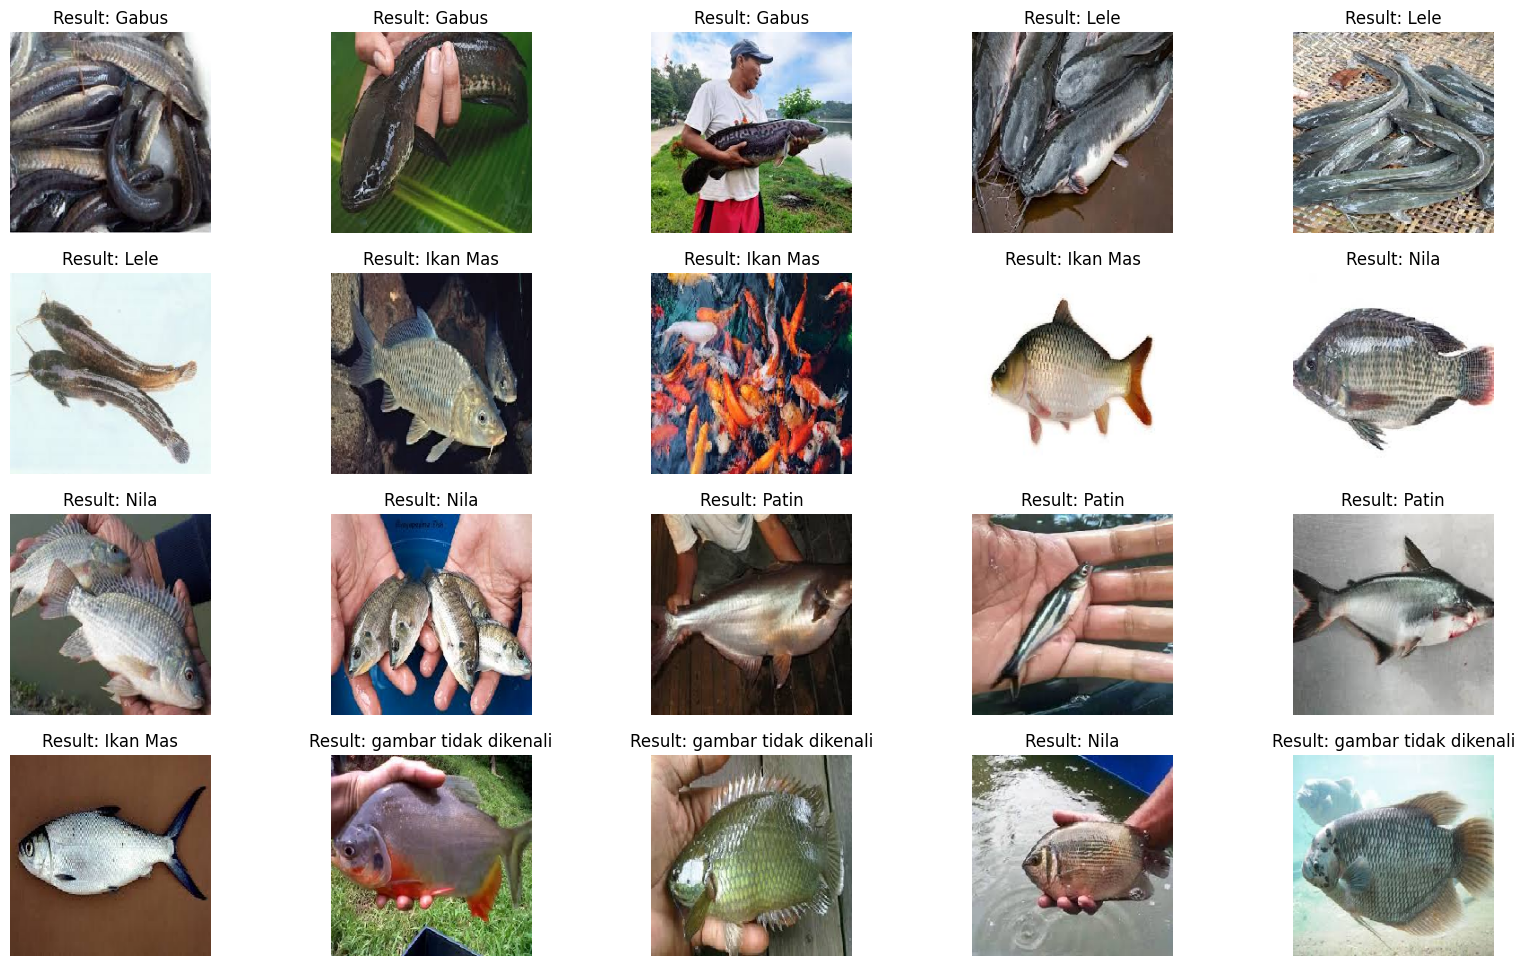

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load model
# loaded_model = load_model('/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/model.h5')

# Upload images
uploaded = files.upload()

# Define class names
class_names = ['Gabus', 'Ikan Mas', 'Lele', 'Nila', 'Patin']

# Confidence threshold
threshold = 0.6  # You can adjust this value

# Determine the number of rows and columns for the subplot grid
num_images = len(uploaded)
num_cols = 5  # Number of columns in the grid
num_rows = (num_images // num_cols) + (1 if num_images % num_cols != 0 else 0)

fig = plt.figure(figsize=(20, 12))  # Create a new figure with size 20*12 inches to display images and predictions

# Predict and display images
for i, fn in enumerate(uploaded.keys()):
    # Determine path to the uploaded image
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))

    # Convert image to numpy array
    x = img_to_array(img)
    x /= 255  # Normalize
    x = np.expand_dims(x, axis=0)  # Add a new axis to create a batch with one image
    images = np.vstack([x])  # Create a batch of images

    # Predict the class probabilities
    classes = model2.predict(images, batch_size=64)
    predicted_class_index = np.argmax(classes, axis=1)[0]
    predicted_class_probability = np.max(classes, axis=1)[0]

    # Determine if the image is recognized or not
    if predicted_class_probability < threshold:
        result = "gambar tidak dikenali"
    else:
        result = class_names[predicted_class_index]

    # Display the image and prediction
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    ax.axis('Off')  # Don't show axes
    plt.imshow(img)
    plt.title('Result: ' + result)

plt.show()

#**Download Model**

In [ ]:
import pickle
from google.colab import files

# convert to .pb format
tf.saved_model.save(model2, '/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/saved_model')

#**Convert Model to tfjs**

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model '/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/saved_model' '/content/drive/MyDrive/CAPSTONE/Dataset_Ikan/tfjs_model'

2024-06-03 04:11:19.222535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 04:11:21.178712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-03 04:11:36.089058: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-06-03 04:11:36.089276: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
